In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2022/lesson9')

Mounted at /content/drive


# Neural Network Application Examples

## Implied Volatility

<!-- * A very useful application of NN regression is *model calibration* which consists of deriving parameters of a model directly from market values.
  * especially convenient to estimate parameters (e.g. volatility) which are otherwise complicated to compute. -->

* *Historical volatility* is the realized volatility of an asset over a previous time period. 
  * It is determined by measuring the standard deviation of its price during that time period.
  * Volatility shifts as market goes through different regimes. Thus, historical volatility may not be an accurate measure of future volatility. 

* *Implied volatility* is the expected future volatility of the asset that is implied by the price of the security's options. 
  * It can be derived from the price of an option (e.g. inverting the Black and Scholes formula).
  * Implied volatility looks toward the future by taking into account all the information used by market participants to determine prices in the options market, instead of just past prices.

### NN Implementation
  
* Assume we need to estimate a stock *implied volatilty* in real time, so we will develop a NN capable of approximate the following function

$$ \sigma = F^{-1}(P_\textrm{call}, S_0, K, r, \mathrm{ttm})\\[5pt]$$

1. **Prepare the training sample** made of a big table with columns: $S_0, K, r, \sigma, \mathrm{ttm}, P_\textrm{call}$
  * such a dateset could help in training different NN according to how $X$, and $y$ columns are split.

* Here, for simplicity, we are going to use at-the-money options ($S_0 = K = 100$) and set time to maturity to 1. 


In [2]:
# read sample
import pandas as pd

df =  pd.read_csv("/content/drive/MyDrive/finance_course/Projects/bs_training_sample.csv", index_col=0)
print (df.describe())

               rate           vol         price
count  46000.000000  46000.000000  46000.000000
mean       0.055500      0.349500     16.402708
std        0.026557      0.144339      5.537397
min        0.010000      0.100000      4.485236
25%        0.032750      0.224750     11.772108
50%        0.055500      0.349500     16.419335
75%        0.078250      0.474250     21.103698
max        0.101000      0.599000     27.524726


2. **Preprocess the dataset**: here it is even more clear the necessity of the scaling, each column has a different range of variation.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scale_X = MinMaxScaler()
scale_y = MinMaxScaler()

X_scaled = scale_X.fit_transform(df[['rate', 'price']])
y_scaled = scale_y.fit_transform(df[['vol']])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

3. **Study the NN architecture** trying various combinations of neuron/layer and hidden layers.

<center>

![](https://drive.google.com/uc?id=1A2V-aoDNYYAIO-SNHvthoay3Ixj6J8Zq)

</center>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(20, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=1500, verbose=1)

4. **Save model and scalers to file**: when the training is long it is advisable to use the NN when needed.

In [ ]:
import joblib

job_name = '/content/drive/MyDrive/finance_course/2022/lesson9/implied_vol'
model.save(job_name)

joblib.dump(scale_X, job_name + "_x_scaler.save")
joblib.dump(scale_y, job_name + "_y_scaler.save")

['/content/drive/MyDrive/finance_course/2022/lesson9/implied_vol_y_scaler.save']

5. **Study NN performance** (loss, overfitting...)

In [4]:
# test for overfitting
from tensorflow.keras.models import load_model

job_name = '/content/drive/MyDrive/finance_course/2022/lesson9/implied_vol'
model = load_model(job_name)

print (model.evaluate(X_train, y_train))
print (model.evaluate(X_test, y_test))

1150/1150 [==============================] - 2s 1ms/step - loss: 1.3805e-07
1.3805257026433537e-07
288/288 [==============================] - 0s 1ms/step - loss: 1.3167e-07
1.3167010592951556e-07


In [8]:
# check prediction for a pair of rate, price
import joblib
from finmarkets import call

scale_X = joblib.load(job_name + "_x_scaler.save")
scale_y = joblib.load(job_name + "_y_scaler.save")

x = [[0.02, 10]]
x_trans = scale_X.transform(x)
pred = scale_y.inverse_transform(model.predict(x_trans))

print (call(100, 100, pred[0][0], 0.02, 1))



1/1 [==============================] - 0s 18ms/step
10.006119776384082


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


<center>

$$\epsilon_{rel} = \frac{P_{pred}-P_{BS}}{P_{BS}}$$

![](https://drive.google.com/uc?id=1ITtdz0Uf9vmKp4ac_IaNRZ0kk1WxdX8Y)

$$\epsilon_{abs} = P_{pred}-P_{BS}$$

![](https://drive.google.com/uc?id=1bTp5cVeFEmwU6CxenEPvCZlS1Yj6wyML)

</center>

* **Neural networks are very bad at extrapolating results.**

In [10]:
x = [[10.0, 0.02]]

x_trans = scale_X.transform(x)
pred = scale_y.inverse_transform(model.predict(x_trans))
print (pred)
print (call(100, 100, pred[0][0], 0.02, 1))



1/1 [==============================] - 0s 18ms/step
[[3.49753]]
92.04685812154963


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


## Bankruptcy Prediction

* The goal is to analyze the possibility an organization would face bankruptcy. 
* Beside the actual classification problem a couple of more concepts are involved here:
  * **imbalanced dataset**: a situation when there is an unequal population of each class in the dataset;
  * **finding the best attributes** to work with through feature selection.

* The Taiwan Economic Journal for the years 1999 to 2009 has listed the details of company bankruptcy. 
  * Data includes 94 numerical attributes that help understand the possibility of bankruptcy.

* input dataset: [bankruptcy_data.csv](https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/bankruptcy_data.csv)


In [11]:
# load data
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/bankruptcy_data.csv")
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.034234,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.000000,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.000000,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.000000,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Given the very large number of available features remove those which present high correlation with other features.

* Numerically compute the feature correlation and define a threshold (e.g.  $|\rho|\geq 0.95$) to remove the attributes above this value.

In [15]:
# compute correlation matrix and remove first col the output label

corr_mat = data.corr()
corr_mat = corr_mat.iloc[1:, 1:]
corr_mat

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
ROA(C) before interest and depreciation before interest,1.000000,0.940124,0.986849,0.334719,0.332755,0.035725,0.053419,0.049222,0.020501,0.051328,...,-0.109272,0.887670,-0.071725,0.008135,0.334721,0.274287,-0.143629,-0.016575,0.010573,0.052416
ROA(A) before interest and % after tax,0.940124,1.000000,0.955741,0.326969,0.324956,0.032053,0.053518,0.049474,0.029649,0.049909,...,-0.156890,0.961552,-0.098900,0.011463,0.326971,0.291744,-0.141039,-0.011515,0.013372,0.057887
ROA(B) before interest and depreciation after tax,0.986849,0.955741,1.000000,0.333749,0.331755,0.035212,0.053726,0.049952,0.022366,0.052261,...,-0.120680,0.912040,-0.089088,0.007523,0.333750,0.280617,-0.142838,-0.014663,0.011473,0.056430
Operating Gross Margin,0.334719,0.326969,0.333749,1.000000,0.999518,0.005745,0.032493,0.027175,0.051438,0.029430,...,-0.032930,0.300143,0.022672,0.004205,1.000000,0.075304,-0.085434,-0.011806,-0.001167,0.120029
Realized Sales Gross Margin,0.332755,0.324956,0.331755,0.999518,1.000000,0.005610,0.032232,0.026851,0.051242,0.029166,...,-0.032920,0.298155,0.022750,0.004038,0.999518,0.074891,-0.085407,-0.011268,-0.001158,0.120196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Net Income to Stockholder's Equity,0.274287,0.291744,0.280617,0.075304,0.074891,0.006216,0.011343,0.010648,0.007693,0.011191,...,0.192688,0.328492,-0.040217,0.000127,0.075303,1.000000,-0.791836,-0.000093,0.005147,0.029622
Liability to Equity,-0.143629,-0.141039,-0.142838,-0.085434,-0.085407,0.001541,-0.004043,-0.004390,-0.011899,-0.002996,...,-0.229559,-0.159697,0.021982,-0.003724,-0.085434,-0.791836,1.000000,0.002119,0.001487,-0.159654
Degree of Financial Leverage (DFL),-0.016575,-0.011515,-0.014663,-0.011806,-0.011268,0.000935,0.000855,0.000927,-0.000556,0.000774,...,-0.001717,-0.010463,-0.001881,-0.008812,-0.011806,-0.000093,0.002119,1.000000,0.016513,-0.016739
Interest Coverage Ratio (Interest expense to EBIT),0.010573,0.013372,0.011473,-0.001167,-0.001158,0.000393,0.000984,0.000957,0.001024,0.000798,...,-0.000974,0.012746,0.000239,0.001027,-0.001169,0.005147,0.001487,0.016513,1.000000,-0.008339


In [16]:
# create dictionary with correlated indices

drop_list = {}

for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) >= 0.95:
            if corr_mat.columns[j] not in drop_list:
                drop_list.setdefault(corr_mat.columns[j], []).append(corr_mat.columns[i])
            
for d in drop_list:
    print (d)

ROA(C) before interest and depreciation before interest
ROA(A) before interest and % after tax
Operating Gross Margin
Pre-tax net Interest Rate
After-tax net Interest Rate
Net Value Per Share (B)
Net Value Per Share (A)
Persistent EPS in the Last Four Seasons
After-tax Net Profit Growth Rate
Debt ratio %
Operating Profit Per Share (Yuan ¥)
Per Share Net profit before tax (Yuan ¥)
Current Liabilities/Liability
Current Liabilities/Equity
Realized Sales Gross Margin
Borrowing dependency
Current Liability to Equity


* These 17 attributes have correlation above threashold therefore they do not bring additional discrimination power to the network so can be safely discarded.

In [17]:
# drop selected columns

data = data.drop(drop_list, axis=1) 

y = data['Bankrupt?'] 
X = data.drop(['Bankrupt?'], axis=1)

## Unbalanced Dataset

In [18]:
print (data['Bankrupt?'].value_counts())

0    6599
1     220
Name: Bankrupt?, dtype: int64


* The dataset is highly imbalanced:
  * the main problem with imbalanced classification is there are too few examples of the minority class for a model to effectively learn the decision boundary. 
  
* Reduce the problem by *oversampling* the dataset with the Synthetic Minority Oversampling Technique (SMOT). 
  * SMOT works by selecting examples that are "close" in the feature space, specifically:
    1. a random example from the minority class is chosen;
    2. then $k$ of the nearest neighbors for that example are found; 
    3. a randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

<img src="https://drive.google.com/uc?id=1Wu5o-3nzpstP4KNRTg9jEeMKvmhi1vvB">

* The approach is effectivesince the new synthetic examples of the minority class are plausible, that is, are relatively close in feature space to existing examples from the minority class.
  * A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples *if there is a strong overlap for the classes*.

* In $\tt{python}$ SMOT algorithm is implemented in $\tt{imblearn.over\_sampling}$ module.



In [19]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)

* The last preparation step is dataset normalization which is necessary since each column values range very differently.


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2)

* Now we can define the neural network architecture and go on with the training.

* **Classification networks are very similar to regression ones**, only striking differences being:
  * the output layer has a number of nodes equal to the classes and the **softmax** activation function;
  * loss function **binary_crossentropy** or **catergorical_crossentropy**.

In [21]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(77, input_dim=X_sm.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(77, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam')

history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
330/330 [==============================] - 2s 3ms/step - loss: 0.3250 - val_loss: 0.2504
Epoch 2/50
330/330 [==============================] - 1s 3ms/step - loss: 0.2261 - val_loss: 0.2031
Epoch 3/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1918 - val_loss: 0.1724
Epoch 4/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1649 - val_loss: 0.1626
Epoch 5/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1455 - val_loss: 0.1514
Epoch 6/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1312 - val_loss: 0.1314
Epoch 7/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1173 - val_loss: 0.1218
Epoch 8/50
330/330 [==============================] - 1s 3ms/step - loss: 0.1048 - val_loss: 0.1067
Epoch 9/50
330/330 [==============================] - 1s 3ms/step - loss: 0.0963 - val_loss: 0.0949
Epoch 10/50
330/330 [==============================] - 1s 3ms/step - loss: 0.0866 - val_loss: 0.0851

[]

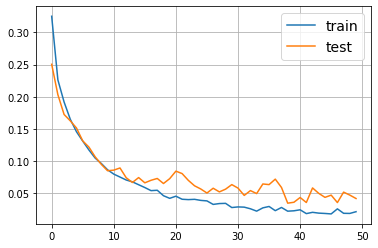

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid(True)
plt.legend(fontsize=14)
plt.plot()

* Performance can be estimated with the *confusion matrix*

$$\begin{pmatrix}
TN & FN \\
FP & TP
\end{pmatrix}
$$


83/83 [==============================] - 0s 2ms/step


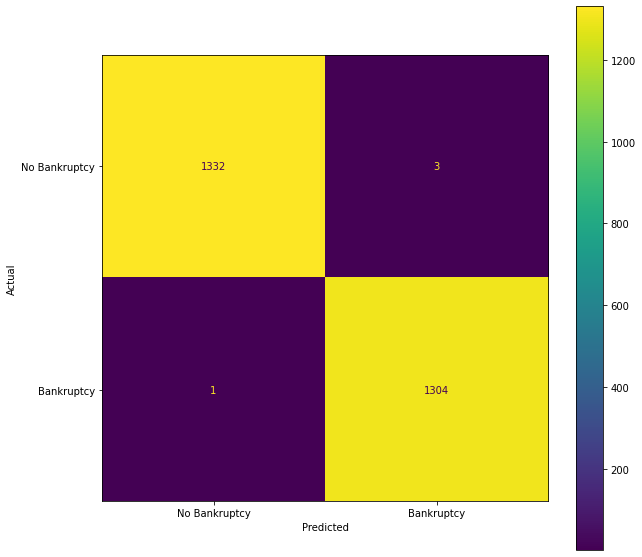

In [23]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.rcParams['figure.figsize'] = (10, 10)
model = load_model("/content/drive/MyDrive/finance_course/2022/lesson9/bankrupticy")
ann_predictions = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, ann_predictions)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['No Bankruptcy', 'Bankruptcy'])
cmd_obj.plot()
cmd_obj.ax_.set(title='', xlabel='Predicted', ylabel='Actual')
plt.show()


* From this matrix many interesting quantities can be computed

$\textrm{mis-classification} = \frac{FN + FP}{n} = 0.11\%$

$\textrm{sensitivity} = \frac{TP}{FN + TP} = 99.8 \%$ (the proportion of true positives that are correctly identified, how good is NN to predict bankruptcy). 

$\textrm{specificity} = \frac{TN}{FP + TN} = 100 \%$ (the proportion of the true negatives correctly identified, how good is NN at predict no-bankruptcy)

$\textrm{accuracy} = \frac{TN+TP}{n} = 99.9\%$ (the proportion of true results, measures the degree of veracity of the NN).

# Image Recognition a Classification Problem

* Visual pattern recognition is an hard task.
  * It becomes apparent if you attempt to write a computer program to recognize digits like those below

<center>

![](https://drive.google.com/uc?id=1GDYJVbHF6sMgcW-siKPchbTQhpKG8TgL)

</center>

* NN approach the problem in a different way since they take a large number of handwritten digits and then develop a system which can learn from those. 
  * By increasing the number of training examples, the network can learn more and more about handwriting, and improve its accuracy. 
  * **NN are not capable of extrapolating, hence they won't recongnize a digit with a style not included in the training sample !!!**).

* Images can be threated as matrices: 
  * grayscale image, each pixel is a number ranging from 0 (black) to 255 (white);
  * colored image, each pixel is a triplet of numbers ranging from 0 to 255 representing Red, Green and Blue component intensity.

#### Image Transformations

* Every image can be "transformed" by convolving it with a "kernel" (mask)

<center>

![](https://drive.google.com/uc?id=17qQOtzCLzqAxZ6uTs1pgvKU_oS7pcjkG)

</center>

* *Sobel* kernels highlights edges in the images

<center>

<table>
<tr>
<td><img width=400 src="https://drive.google.com/uc?id=1Nleg_88q6_218xlqXEJDo4y-GZIZLibA"></td>
<td><img src="https://drive.google.com/uc?id=1kvtMr-FZKUq9ts9lznJzFu3ZBHB9vfhP"></td>
<td><img src="https://drive.google.com/uc?id=1m1RldHjNd5nhUldkVOwrzEQE_e6zwrZT"></td>
</tr>
</table>

</center>

* *Gaussian blur* blur the image

<center>

<table>
<tr>
<td><img width=400 src="https://drive.google.com/uc?id=1Nleg_88q6_218xlqXEJDo4y-GZIZLibA"></td>
<td><img src="https://drive.google.com/uc?id=105cJL6HgwcaiisxhOWzIwXifT76xNTYa"></td>
</tr>
</table>

</center>

### Convolutional Neural Network (CNN)

* **Instead of providing pre-defined kernels, a CNN learns the specific ones that better highlight the features of the training dateset**:
  * ANN: the model parameters are the neuron weights;
  * CNN: the model parameters are the kernel matrices. 
  
* The CNN classifies images according to their relevant charateristics stacking many kernels.

* Other typical transformation used in CNN is **MaxPooling** which reduce the granularity of big images to focus on the real features.

<center>

![](https://drive.google.com/uc?id=1lq2yjbjRKQkAfJ81ob4WLkC5ROt-CF8E)

</center>


### Technical Analysis

* *Technical analysis* is a discipline for forecasting the direction of prices through the study of past market data (primarily price and volume).
* The analyst looks for particular patterns in the price time series that are **believed** to develop in predictable ways to take profit of it.

<center>

![](https://drive.google.com/uc?id=16TnvlNEZgDWYxz2SMrFB8rkOjYeOGWeK)

![](https://drive.google.com/uc?id=1B9nSrIgPjdhyjzXF1DZtVyArQc5sKYCr)

</center>



## Example Santa Detector

* Want to develop a CNN capable of classify images according to the presence of Santa Claus.

1. **Dataset preparation**: collected about 1000 images with and without Santa
  * each image has also been converted into gray scale and resized to 150x150 pixels;
  * there are many other transformation techniques (rotation, flip, crop, etc…)that could be applied to improve the result, not doing here.

2. **Network architecture**: performed two trainings with the same network: 
  * one on the black and white version;
  * the other with colored images.

<center>

<img src="https://drive.google.com/uc?id=1A30PrWTXt7EqDcmpSo8CiMjPqo-VyQbV">

</center>

In [ ]:
# Define the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(64,(3, 3), activation='relu', input_shape=(150, 150, 3), data_format="channels_last"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256,(3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', name='dense1'))
model.add(Dense(2, activation='softmax', name='dense2'))

model.compile(loss='categorical_crossentropy', optimizer="adam")

* **Create dataset directly from the directories containing the images**.

In [ ]:
# Train the model
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    class_mode='categorical',    
                                                    #color_mode='grayscale'
                                                    )

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150,150),
                                                        class_mode='categorical',
                                                        #color_mode='grayscale'
                                                        )

history = model.fit(train_generator, epochs=9)

In [ ]:
# Load trained models
import os
from tensorflow.keras.models import load_model

base_dir = "/content/drive/MyDrive/finance_course/2022/lesson9"
classifiers = []
classifiers.append(load_model(os.path.join(base_dir, 'santa_detector_short_v2')))
classifiers.append(load_model(os.path.join(base_dir, 'santa_detector_short_bw')))
classifiers.append(load_model(os.path.join(base_dir, 'santa_detector_long')))

### Training Performance

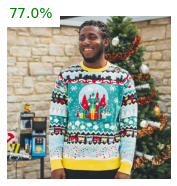

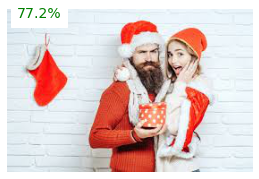

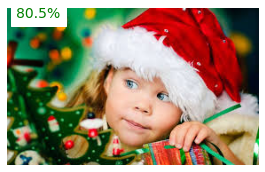

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def img_load(f):
  img = load_img(f, target_size = (150, 150))   
  img = img_to_array(img) /255
  return np.expand_dims(img, axis = 0)

def img_load_bw(f):
  img = load_img(f, target_size = (150, 150), color_mode='grayscale')   
  img = img_to_array(img) /255
  return np.expand_dims(img, axis = 0)

test_dir = validation_dir = os.path.join(base_dir, 'validation/not')

plt.rcParams['figure.figsize'] = (4.5, 3)
for f in os.listdir(test_dir):
  f = os.path.join(test_dir, f)
  img = img_load(f)

  results = classifiers[0].predict(img, verbose=0)
  if results[0][1] > 0.7:
    fig, ax = plt.subplots(1, 1)
    test_img = Image.open(os.path.join(test_dir, f))
    ax.imshow(test_img)
    ax.text(10, 10, "{:.1f}%".format(results[0][1]*100), color='green', backgroundcolor='white', fontsize=14)
    ax.axis('off')

## Overfitting

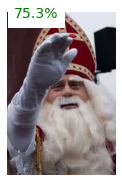

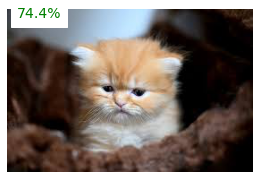

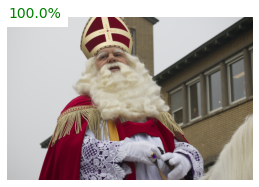

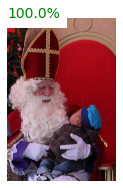

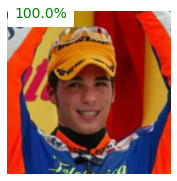

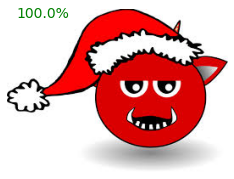

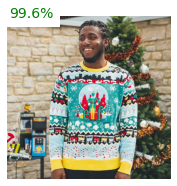

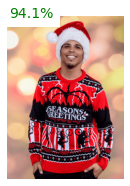

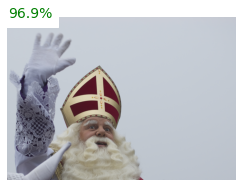

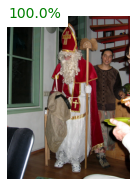

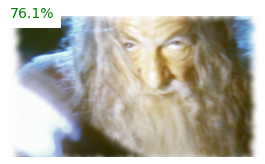

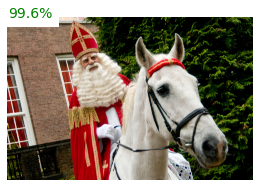

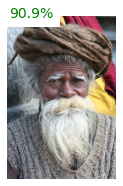

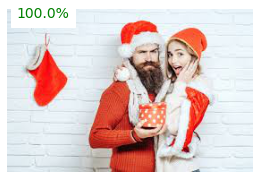

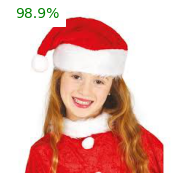

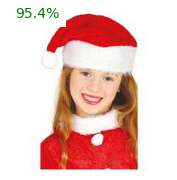

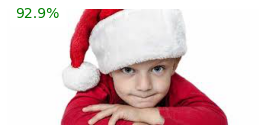

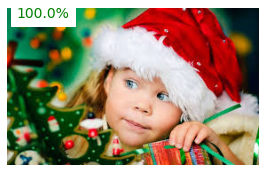

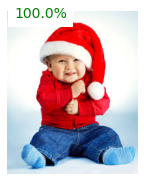

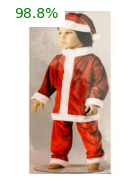

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def img_load(f):
  img = load_img(f, target_size = (150, 150))   
  img = img_to_array(img) /255
  return np.expand_dims(img, axis = 0)

def img_load_bw(f):
  img = load_img(f, target_size = (150, 150))   
  img = img_to_array(img) /255
  return np.expand_dims(img, axis = 0)

test_dir = validation_dir = os.path.join(base_dir, 'validation/not')

plt.rcParams['figure.figsize'] = (4.5, 3)
for f in os.listdir(test_dir):
  f = os.path.join(test_dir, f)
  img = img_load(f)

  results = classifiers[2].predict(img, verbose=0)
  if results[0][1] > 0.7:
    fig, ax = plt.subplots(1, 1)
    test_img = Image.open(os.path.join(test_dir, f))
    ax.imshow(test_img)
    ax.text(10, 10, "{:.1f}%".format(results[0][1]*100), color='green', backgroundcolor='white', fontsize=14)
    ax.axis('off')

In [ ]:
test_dir = os.path.join(base_dir, "test")

plt.rcParams['figure.figsize'] = (9, 6)
for f in os.listdir(test_dir):
  f = os.path.join(test_dir, f)
  img = img_load(f)
  img_bw = img_load_bw(f)

  results = []
  results.append(classifiers[0].predict(img, verbose=0))
  results.append(classifiers[1].predict(img_bw, verbose=0))

  fig, ax = plt.subplots(1, 2)
  test_img = Image.open(os.path.join(test_dir, f))
  test_img_bw = test_img.convert("L")
  ax[0].imshow(test_img)
  ax[0].text(10, 10, "{:.1f}%".format(results[0][0][1]*100), color='green', backgroundcolor='white', fontsize=14)
  ax[0].axis('off')
  ax[1].imshow(test_img_bw, cmap='gray')
  ax[1].text(10, 10, "{:.1f}%".format(results[1][0][1]*100), color='green', backgroundcolor='white', fontsize=14)
  ax[1].axis('off') 

Output hidden; open in https://colab.research.google.com to view.

## Network Interpretability

* NN can be thought of **black boxes**, in general it is very very hard to understand why they behave in a certain way.
* To help understanding Neural Net behavior there are a number of techniques which analyses the weights values at each layer and "backpropagate" the information to the original image highlighting the most "important" pixels in the classification (i.e. the higher the weights the higher the importance)

<table style="width: 100%">
    <colgroup>
       <col span="1" style="width: 30%;">
       <col span="1" style="width: 30%;">
       <col span="1" style="width: 30%;">
    </colgroup>
<tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1pY7XRqhwpo7FWu2bDpEXuUJkiw7b-Vlf">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1nB46GxFwVTuZ4NZtgC9lb7lx93o69Hab">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1CpZqvAmiHswyNPume4TOdBSb_EZLhVW6">
</td>
</tr>
<tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1P-8VR-_1cl6ljb7we71b3OU0phjErah5">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1HM6a4EXPWaWre-NQvGPs0GU06On0deHp">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1faGAL5BOqV_Nx4V4IZ4PxCzi7nlbXAyw">
</td>
</tr>
<tr>
<td><img width=300 src="https://drive.google.com/uc?id=16iPuxuJe5iTlnJuBJOeNrle1RIev6-MZ">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1ql4rDjons1ZdNpbyyD7S4b6ic7zzRvZT">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1tvsX6dC2kr9h74Ntf_zXaXak3O0lwQAH">
</td>
</tr>
<!-- <tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1Hy4PPMrhc064GPU6dErB0gMVp1HGOuGR">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1YjsL6umIFPdLyOVMDdyiyvi4Le-rB-N3">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1SjvP1HmPC_RL3H47zuoEcQRavUdAtGiv">
</td>
</tr> -->
<!-- <tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1K4k29pLBOHpmYjtxz6l88FhMyCLQavML">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1YZcXC_Q2iRsFeoxTpE5vOB0CRcXyCyZ2">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1K5Yg_PDxzga9uenAwW1MBVR4eRbhrCxb">
</td>
</tr> -->
<!-- <tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1lXb7BWab1nn2bpntMoA4GjRyUL1PWHVW">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1O-T-u6SGKkvhkf0vIttYFjgSN8DVTu4N">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1sYdpQXYCYehyZWCCAqnbpJAz-P6pO3CI">
</td>
</tr>
<tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1R_4wFm_YDRmYpTkXbUyX9BgKnDfZFipe">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1jrhoE0y7gh0AvnuuoPUZvttcKCB-wiK4">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1pSh0919GDCZXr1ICteNkzjZPAO8BUxIV">
</td>
</tr>
<tr> 
<td><img width=300 src="https://drive.google.com/uc?id=1tWEtId5-EzW62kI5aer7GqZHnDLzob-a">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1jSsyymcIyXg4E4DXHnmFyOeoPUpJlega">
</td>
<td><img width=600 src="https://drive.google.com/uc?id=1Jmc1vwTCnHoMtlWyqCvtdXgETabMwHvT">
</td>
</tr> -->
</table>

# Unsupervised Learning



* Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data.
* As a result, unsupervised learning algorithms must first self-discover any naturally occurring patterns in that training data set. 
  * **clustering**: where the algorithm automatically groups its training examples into categories with similar features;
  * **principal component analysis** where the algorithm finds ways to compress the training data set by identifying which features are most useful for discriminating between different training examples, and discarding the rest. 

## k-Means Algorithm

* k-means clustering aims to partition (split) $n$ observations into $k$ clusters in which each point belongs to the cluster with the nearest mean (cluster centers or cluster centroid). 
  * Given observations $(x_1, x_2, \ldots, x_n)$ the algorithm divides the $n$ observations into $k$ $(\leq n)$ sets $S = \{S_1, S_2, \ldots, S_k\}$  to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 

#### Example
* Cluster SP500 stocks using historical returns and volatilities.
  * Input dataset: [k_mean.csv](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/k_mean.csv), consists of the daily closing price series within the interval 2018-09-20, 2021-09-20.
  * The goal is to find similarities amongst companies. To do this, the k-means clustering algorithm will produce labels that assign each company to different clusters.


* First load the inputs and produce a new DataFrame with annualized returns and volatilities for each stock. 

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/k_mean.csv", index_col='Date')

returns = df.pct_change().mean() * 252
std = df.pct_change().std() * np.sqrt(252)

ret_var = pd.concat([returns, std], axis = 1).dropna()
ret_var.columns = ["Returns","Standard Deviation"]
print (ret_var.head())

       Returns  Standard Deviation
MMM  -0.188903            0.261649
ABT   0.235801            0.232519
ABBV -0.159596            0.304667
ABMD -0.543486            0.526830
ACN   0.152511            0.212579


#### Elbow Curve

* To determine the optimal number of clusters $k$ for our dataset, fit different models of the k-means algorithm while varying the parameter $k$ (e.g. in range [2, 14]). 
  * For each model calculate the Sum Squared Error (SSE) by using the $\texttt{.inertia__}$ method
    * inertia tells how far away the points within a cluster are; 
    * the smaller the inertia value the better.



* Each pair of values ($k$, SSE) will construct the **Elbow Curve** which can be used to determine the optimal value for $k$. 

* Using the "elbow" of a curve as a cutoff point is a common heuristic in mathematical optimization
  * choose a point where diminishing returns are no longer worth the additional cost. 
  * In clustering, this means one should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.
  * Increasing the number of clusters will naturally improve the fit but at some point too many clusters causes over-fitting (start sub-dividing "real" clusters). 
* In practice there may not be a sharp elbow, and as a heuristic method, such an "elbow" cannot always be unambiguously identified.

In [ ]:
from sklearn.cluster import KMeans

X =  ret_var.values 
sse = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
  
    sse.append(kmeans.inertia_) 

<img src="https://drive.google.com/uc?id=1UCj2T2iDthU9oCBiTFihMpwPcGFi7uFN">

* The resulting graph shows that the optimal value of $k$ is 5.

In [ ]:
kmeans = KMeans(n_clusters = 5).fit(X)
centroids = kmeans.cluster_centers_

<img src="https://drive.google.com/uc?id=1nASwJdewartvCjY7LYBotS9ilgI-Z8AN">

* Note the outlier on the upper right side of the graph. 
  * This outlier form its own cluster. 
  * To improve categorization  remove that point and fit the model another time.
  * This is done by finding the stock with the highest standard deviation value and dropping the corresponding columnn.

In [ ]:
stdOrder = ret_var.sort_values('Standard Deviation', ascending=False)
first_symbol = stdOrder.index[0]
ret_var.drop(first_symbol, inplace=True)

In [ ]:
X = ret_var.values
kmeans = KMeans(n_clusters = 5).fit(X)
centroids = kmeans.cluster_centers_

<img src="https://drive.google.com/uc?id=1Tkza6qmZPrJYDDdgHDwLjwjRLKJPxtoV">

* Finally assign to each stock its correspondent cluster label (1, 2, 3, 4, and 5). 
* Having that information could help in creating a diversified portfolio in the long term, between stocks from different clusters.

In [ ]:
stocks = pd.DataFrame(ret_var.index) # the dataframe structure allow concatenation
cluster_labels = pd.DataFrame(kmeans.labels_)
stockClusters = pd.concat([stocks, cluster_labels],axis = 1)
stockClusters.columns = ['Symbol','Cluster']


In [ ]:
print (stockClusters.loc[stockClusters['Cluster'] == 0, 'Symbol'])

### Natual Language Processing

* K-means algorithmm can also be used in Natural Language Processing (NLP).
  * NLP is an AI subfield concerned with the analysis of large amounts of natural language data.

* In there words (or sentences) are transformed into a set of numbers which then can be clustered together with k-means methods for a **sentiment analysis**.